### Resources:

#### 1. Fourier Transform 

Interactive Website:
- https://www.jezzamon.com/fourier/
- https://www.falstad.com/fourier/

3Blue1Brown: https://www.youtube.com/watch?v=spUNpyF58BY

#### 2. Multitaper Spectral Estimation

Prerau's Lab (https://prerau.bwh.harvard.edu/) Youtube Tutorial on Multitaper Methods:
https://www.youtube.com/watch?v=OVsZJLtzNsw&list=PLUhCVmP2y7PAQpaqCc6ANMjWwPZ2rbJeE

https://docs.stingray.science/en/stable/notebooks/Multitaper/multitaper_example.html

#### 3. Reference Papers: 

Investigating large-scale brain dynamics using field potential recordings: analysis and interpretation

Bijan Pesaran, Martin Vinck, Gaute T. Einevoll, Anton Sirota, Pascal Fries, Markus Siegel, Wilson Truccolo, Charles E. Schroeder & Ramesh Srinivasan 

https://www.nature.com/articles/s41593-018-0171-8

Gamma oscillations dynamically couple hippocampal CA3 and CA1 regions during memory task performance 
(Sean M. Montgomery and György Buzsáki)

https://www.pnas.org/doi/10.1073/pnas.0701826104?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub++0pubmed

# 📜 Epicycles and the Ptolemaic Model of the Universe

In ancient astronomy, the **Ptolemaic model** placed the Earth at the center of the universe.  
To explain the observed motion of planets astronomers introduced the concept of **epicycles**.

An **epicycle** is a small circle whose center moves along a larger circle.
The planet was thought to move along the epicycle, creating looping paths in the sky.

Although this model was eventually replaced by the heliocentric model (Sun-centered), the idea of epicycles lives on — especially in **Fourier analysis**, where complex motions and signals are expressed as sums of rotating vectors (modern “epicycles”).

In [ ]:
import numpy as np
from scipy import io, signal, fft, interpolate
from scipy.signal import windows, detrend
from scipy.stats import zscore
import ipywidgets as widgets
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import gridspec

cmap_hot = cm.get_cmap('hot')

/tmp/ipykernel_7814/694445334.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_hot = cm.get_cmap('hot')


In [1]:
from mtspec import multitaper_psd

## 2.1 Periodogram and Window Size

Extract a short segment of data for any one channel. Implement and compute periodogram spectrum estimate from 1 to 100 Hz. Explore the effect of window size choice.  

### 2.1.a Extract a short segment of data

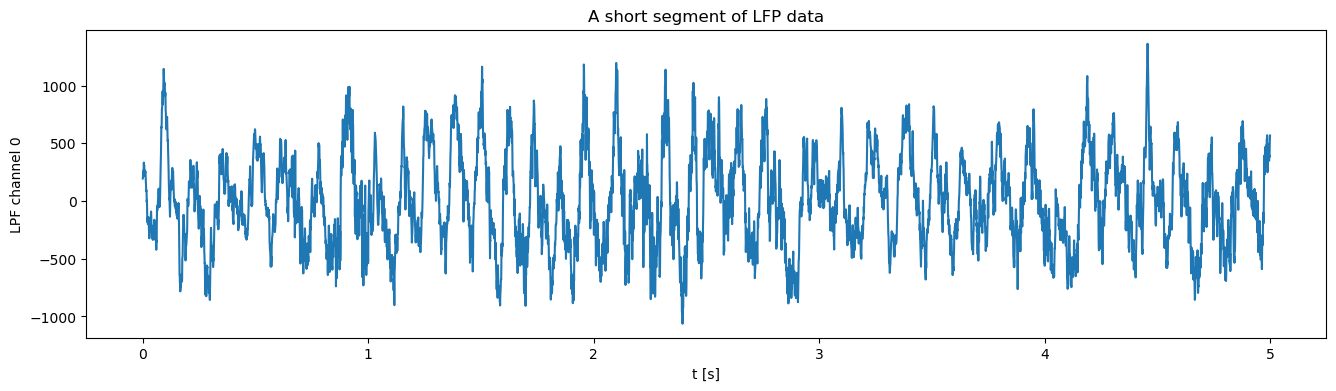

In [ ]:
# load the data
# Data:  16 channels of hippocampal LFP time series from a file lfp_1shank.mat.
# Matrix lfps (1250Hz sampling rate samples x 16 channels) 
full_lfp = io.loadmat('ws_data_1shank.mat')['lfps'] # array of LFP data
full_lfp = full_lfp.astype(np.float32) # convert from int16 to int32 for better precision
fs = 1250 # sampling frequency
dt = 1/fs
window_size = 5 * fs # 5 seconds of data
channel = 0
t = np.arange(window_size)*dt
lfp = full_lfp[:window_size,channel].astype(np.int32)
plt.figure(figsize=(16, 4))
plt.plot(t, lfp)
plt.xlabel('t [s]')
plt.ylabel('LPF channel %d'%channel)
plt.title('A short segment of LFP data')
plt.show()

> ### 💡 Tip: Use Floats for Filtering
> - Avoid filtering with `int16` — it can overflow and lose precision.
> - Always convert signals to `float32` or `float64` before applying filters:
>   ```python
>   x = x.astype(np.float32)
>   ```
> - After filtering, convert back to `int16` only if needed for storage:
>   ```python
>   x_filtered_int16 = np.clip(x_filtered, -32768, 32767).astype(np.int16)
>   ```
> - Float types ensure accurate, stable time-domain filtering.

### 2.1.b Implement and compute periodogram spectrum estimate from 1 to 100 Hz

In [ ]:
def Periodogram_raw(y, fs=1.0):
    N = len(y)
    a = np.fft.fft(y)
    p = (np.abs(a)**2) / N
    f = np.fft.fftfreq(N, d=1/fs)

    # Keep only non-negative frequencies
    half = N // 2
    p = p[:half]
    f = f[:half]
    p[1:-1] *= 2  # optional: for one-sided power

    return p, f

eps = 1e-10  # small value to avoid log(0) in periodogram
def psd_decibel(p):
    """Convert power spectral density to decibels."""
    return 10 * np.log10(np.maximum(p, eps))

def amp_decibel(p):
    """Convert amplitude to decibels."""
    return 20 * np.log10(np.maximum(np.sqrt(p), eps))


p, f = Periodogram_raw(lfp, fs=fs)

# Welch method

In [2]:
# welch method from scipy
from scipy.signal import welch
welch??

Signature:
welch(
    x,
    fs=1.0,
    window='hann',
    nperseg=None,
    noverlap=None,
    nfft=None,
    detrend='constant',
    return_onesided=True,
    scaling='density',
    axis=-1,
    average='mean',
)
Source:   
def welch(x, fs=1.0, window='hann', nperseg=None, noverlap=None, nfft=None,
          detrend='constant', return_onesided=True, scaling='density',
          axis=-1, average='mean'):
    r"""
    Estimate power spectral density using Welch's method.

    Welch's method [1]_ computes an estimate of the power spectral
    density by dividing the data into overlapping segments, computing a
    modified periodogram for each segment and averaging the
    periodograms.

    Parameters
    ----------
    x : array_like
        Time series of measurement values
    fs : float, optional
        Sampling frequency of the `x` time series. Defaults to 1.0.
    window : str or tuple or array_like, optional
        Desired window to use. If `window` is a string or tuple, it is

# Multitaper

In [3]:
from mtspec import multitaper_psd

multitaper_psd??

Signature:
multitaper_psd(
    y: Union[numpy.__array_like._SupportsArray[numpy.dtype[Any]], numpy.__nested_sequence._NestedSequence[numpy.__array_like._SupportsArray[numpy.dtype[Any]]], bool, int, float, complex, str, bytes, numpy.__nested_sequence._NestedSequence[Union[bool, int, float, complex, str, bytes]]],
    axis: int = -1,
    NW: float = 2,
    nfft: int = None,
    K_max: int = None,
    fs: float = 1,
    detrend: bool = False,
    n_fft_threads: int = 8,
) -> Tuple[numpy.ndarray, numpy.ndarray]
Source:   
def multitaper_psd(y: ArrayLike,
                   axis: int = -1,
                   NW: float = 2,
                   nfft: int = None,
                   K_max: int = None,
                   fs: float = 1,
                   detrend: bool = False,
                   n_fft_threads: int = cpu_count()) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the multitaper power spectral density (PSD) of a signal.

    Parameters
    ----------
    y : ArrayLike
        In